In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dense, Flatten, Softmax

print(tf.__version__)

2.0.0


# Exploring the data

In [2]:
mnist = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
HEIGHT, WIDTH = x_train[0].shape
NCLASSES = tf.size(tf.unique(y_train).y)
print("Image height x width is", HEIGHT, "x", WIDTH)
tf.print("There are", NCLASSES, "classes")

Image height x width is 28 x 28
There are 10 classes


The label for image number 12 is 9


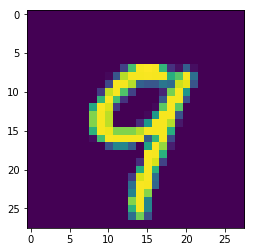

In [4]:
IMGNO = 12
# Uncomment to see raw numerical values.
# print(x_test[IMGNO])
plt.imshow(x_test[IMGNO].reshape(HEIGHT, WIDTH));
print("The label for image number", IMGNO, "is", y_test[IMGNO])

# Define the model

In [5]:
def linear_model():
    model = Sequential([
        Flatten(),
        Dense(NCLASSES),
        Softmax()
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Write Input Functions

In [6]:
BUFFER_SIZE = 5000
BATCH_SIZE = 100


def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label


def load_dataset(training=True):
    """Loads MNIST dataset into a tf.data.Dataset"""
    (x_train, y_train), (x_test, y_test) = mnist
    x = x_train if training else x_test
    y = y_train if training else y_test
    # One-hot encode the classes
    y = tf.keras.utils.to_categorical(y, NCLASSES)
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(scale).batch(BATCH_SIZE)
    if training:
        dataset = dataset.shuffle(BUFFER_SIZE).repeat()
    return dataset

In [7]:
def create_shape_test(training):
    dataset = load_dataset(training=training)
    data_iter = dataset.__iter__()
    (images, labels) = data_iter.get_next()
    expected_image_shape = (BATCH_SIZE, HEIGHT, WIDTH)
    expected_label_ndim = 2
    assert(images.shape == expected_image_shape)
    assert(labels.numpy().ndim == expected_label_ndim)
    test_name = 'training' if training else 'eval'
    print("Test for", test_name, "passed!")


create_shape_test(True)
create_shape_test(False)

Test for training passed!
Test for eval passed!


In [8]:
NUM_EPOCHS = 10
STEPS_PER_EPOCH = 100

model = linear_model()
train_data = load_dataset()
validation_data = load_dataset(training=False)

OUTDIR = "mnist_linear/"
checkpoint_callback = ModelCheckpoint(
    OUTDIR, save_weights_only=True, verbose=1)
tensorboard_callback = TensorBoard(log_dir=OUTDIR)

history = model.fit(
    train_data, 
    validation_data=validation_data,
    epochs=NUM_EPOCHS, 
    steps_per_epoch=STEPS_PER_EPOCH,
    verbose=2,
    callbacks=[checkpoint_callback, tensorboard_callback]
)

Train for 100 steps, validate for 100 steps
Epoch 1/10

Epoch 00001: saving model to mnist_linear/
100/100 - 6s - loss: 1.3242 - accuracy: 0.6767 - val_loss: 0.7977 - val_accuracy: 0.8269
Epoch 2/10

Epoch 00002: saving model to mnist_linear/
100/100 - 1s - loss: 0.6764 - accuracy: 0.8461 - val_loss: 0.5603 - val_accuracy: 0.8669
Epoch 3/10

Epoch 00003: saving model to mnist_linear/
100/100 - 3s - loss: 0.5311 - accuracy: 0.8691 - val_loss: 0.4698 - val_accuracy: 0.8857
Epoch 4/10

Epoch 00004: saving model to mnist_linear/
100/100 - 2s - loss: 0.4783 - accuracy: 0.8778 - val_loss: 0.4209 - val_accuracy: 0.8960
Epoch 5/10

Epoch 00005: saving model to mnist_linear/
100/100 - 1s - loss: 0.4292 - accuracy: 0.8896 - val_loss: 0.3883 - val_accuracy: 0.9009
Epoch 6/10

Epoch 00006: saving model to mnist_linear/
100/100 - 2s - loss: 0.3729 - accuracy: 0.9022 - val_loss: 0.3735 - val_accuracy: 0.9022
Epoch 7/10

Epoch 00007: saving model to mnist_linear/
100/100 - 5s - loss: 0.3876 - accurac

# Benchmark와 비교

In [14]:
BENCHMARK_ERROR = .12
BENCHMARK_ACCURACY = 1 - BENCHMARK_ERROR

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('accuracy:{}\nval_accuracy:{}\nloss:{}\nval_loss:{}\n'.format(accuracy[-1], val_accuracy[-1], loss[-1], val_loss[-1]))
    
assert(accuracy[-1] > BENCHMARK_ACCURACY)
assert(val_accuracy[-1] > BENCHMARK_ACCURACY)
print("Test to beat benchmark accuracy passed!")
        
assert(accuracy[0] < accuracy[1])
assert(accuracy[1] < accuracy[-1])
assert(val_accuracy[0] < val_accuracy[1])
assert(val_accuracy[1] < val_accuracy[-1])
print("Test model accuracy is improving passed!")
    
assert(loss[0] > loss[1])
assert(loss[1] > loss[-1])
assert(val_loss[0] > val_loss[1])
assert(val_loss[1] > val_loss[-1])
print("Test loss is decreasing passed!")

accuracy:0.90420001745224
val_accuracy:0.9117000102996826
loss:0.3416840773820877
val_loss:0.32351552169770004

Test to beat benchmark accuracy passed!
Test model accuracy is improving passed!
Test loss is decreasing passed!


# Evaluating Predictions

In [22]:
image_numbers = range(0, 10, 1)  # Change me, please.

def load_prediction_dataset():
    dataset = (x_test[image_numbers], y_test[image_numbers])
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.map(scale).batch(len(image_numbers))
    return dataset

predicted_results = model.predict(load_prediction_dataset())
for index, prediction in enumerate(predicted_results):
    predicted_value = np.argmax(prediction)
    actual_value = y_test[image_numbers[index]]
    print("[{}] prediction : {}     actual label:{}".format(index,predicted_value, actual_value))
    if actual_value != predicted_value:
        print("image number: " + str(image_numbers[index]))
        print("the prediction was " + str(predicted_value))
        print("the actual label is " + str(actual_value))
        print("")

[0] prediction : 7     actual label:7
[1] prediction : 2     actual label:2
[2] prediction : 1     actual label:1
[3] prediction : 0     actual label:0
[4] prediction : 4     actual label:4
[5] prediction : 1     actual label:1
[6] prediction : 4     actual label:4
[7] prediction : 9     actual label:9
[8] prediction : 6     actual label:5
image number: 8
the prediction was 6
the actual label is 5

[9] prediction : 9     actual label:9


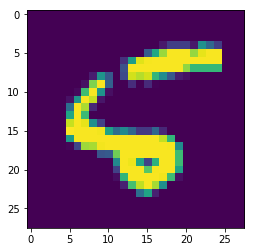

In [23]:
bad_image_number = 8
plt.imshow(x_test[bad_image_number].reshape(HEIGHT, WIDTH));

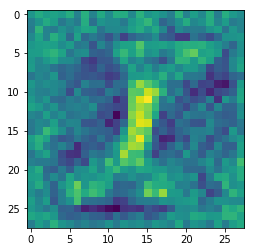

In [30]:
DIGIT = 1  # Change me to be an integer from 0 to 9.
LAYER = 1  # Layer 0 flattens image, so no weights
WEIGHT_TYPE = 0  # 0 for variable weights, 1 for biases

dense_layer_weights = model.layers[LAYER].get_weights()
digit_weights = dense_layer_weights[WEIGHT_TYPE][:, DIGIT]
plt.imshow(digit_weights.reshape((HEIGHT, WIDTH)))